In [76]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import os
import gc
from tqdm import tqdm_notebook
import random
import xgboost as xgb
from sklearn.model_selection import KFold
import scipy as sp
from sklearn import metrics
from tsfresh.feature_extraction import feature_calculators
import matplotlib.pyplot as plt

print(os.listdir("../input"))

['train.csv', 'test', 'sample_submission.csv', '.ipynb_checkpoints', 'train.zip', 'train.feather']


In [77]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999

    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here
        # numpy
        feature_dict['mean'] = np.mean(x)
        feature_dict['max'] = np.max(x)
        feature_dict['min'] = np.min(x)
        feature_dict['std'] = np.std(x)
        feature_dict['var'] = np.var(x)
        feature_dict['ptp'] = np.ptp(x)
        feature_dict['percentile_10'] = np.percentile(x, 10)
        feature_dict['percentile_20'] = np.percentile(x, 20)
        feature_dict['percentile_30'] = np.percentile(x, 30)
        feature_dict['percentile_40'] = np.percentile(x, 40)
        feature_dict['percentile_50'] = np.percentile(x, 50)
        feature_dict['percentile_60'] = np.percentile(x, 60)
        feature_dict['percentile_70'] = np.percentile(x, 70)
        feature_dict['percentile_80'] = np.percentile(x, 80)
        feature_dict['percentile_90'] = np.percentile(x, 90)

        # scipy
        feature_dict['skew'] = sp.stats.skew(x)
        feature_dict['kurtosis'] = sp.stats.kurtosis(x)
        feature_dict['kstat_1'] = sp.stats.kstat(x, 1)
        feature_dict['kstat_2'] = sp.stats.kstat(x, 2)
        feature_dict['kstat_3'] = sp.stats.kstat(x, 3)
        feature_dict['kstat_4'] = sp.stats.kstat(x, 4)
        feature_dict['moment_1'] = sp.stats.moment(x, 1)
        feature_dict['moment_2'] = sp.stats.moment(x, 2)
        feature_dict['moment_3'] = sp.stats.moment(x, 3)
        feature_dict['moment_4'] = sp.stats.moment(x, 4)
        
        feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
        feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
        feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
        feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
        feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
        feature_dict['mean_change'] = feature_calculators.mean_change(x)
        feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_m4000_m3000'] = feature_calculators.range_count(x, -4000, -3000)
        feature_dict['range_m3000_m2000'] = feature_calculators.range_count(x, -3000, -2000)
        feature_dict['range_m2000_m1000'] = feature_calculators.range_count(x, -2000, -1000)
        feature_dict['range_m1000_0'] = feature_calculators.range_count(x, -1000, 0)
        feature_dict['range_0_p1000'] = feature_calculators.range_count(x, 0, 1000)
        feature_dict['range_p1000_p2000'] = feature_calculators.range_count(x, 1000, 2000)
        feature_dict['range_p2000_p3000'] = feature_calculators.range_count(x, 2000, 3000)
        feature_dict['range_p3000_p4000'] = feature_calculators.range_count(x, 3000, 4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
        feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
        feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
        feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
        feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)
        feature_dict['time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
        feature_dict['time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
        feature_dict['time_rev_asym_stat_1000'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1000)
        feature_dict['autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
        feature_dict['autocorrelation_10'] = feature_calculators.autocorrelation(x, 10)
        feature_dict['autocorrelation_50'] = feature_calculators.autocorrelation(x, 50)
        feature_dict['autocorrelation_100'] = feature_calculators.autocorrelation(x, 100)
        feature_dict['autocorrelation_1000'] = feature_calculators.autocorrelation(x, 1000)
        feature_dict['c3_5'] = feature_calculators.c3(x, 5)
        feature_dict['c3_10'] = feature_calculators.c3(x, 10)
        feature_dict['c3_100'] = feature_calculators.c3(x, 100)
        feature_dict['fft_1_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'real'}]))[0][1]
        feature_dict['fft_1_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'imag'}]))[0][1]
        feature_dict['fft_1_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'angle'}]))[0][1]
        feature_dict['fft_2_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'real'}]))[0][1]
        feature_dict['fft_2_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'imag'}]))[0][1]
        feature_dict['fft_2_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'angle'}]))[0][1]
        feature_dict['fft_3_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'real'}]))[0][1]
        feature_dict['fft_3_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'imag'}]))[0][1]
        feature_dict['fft_3_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'angle'}]))[0][1]
        feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
        feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
        feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
        feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)
        feature_dict['binned_entropy_5'] = feature_calculators.binned_entropy(x, 5)
        feature_dict['binned_entropy_10'] = feature_calculators.binned_entropy(x, 10)
        feature_dict['binned_entropy_20'] = feature_calculators.binned_entropy(x, 20)
        feature_dict['binned_entropy_50'] = feature_calculators.binned_entropy(x, 50)
        feature_dict['binned_entropy_80'] = feature_calculators.binned_entropy(x, 80)
        feature_dict['binned_entropy_100'] = feature_calculators.binned_entropy(x, 100)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
        feature_dict['num_peaks_10'] = feature_calculators.number_peaks(x, 10)
        feature_dict['num_peaks_50'] = feature_calculators.number_peaks(x, 50)
        feature_dict['num_peaks_100'] = feature_calculators.number_peaks(x, 100)
        feature_dict['num_peaks_500'] = feature_calculators.number_peaks(x, 500)

        feature_dict['spkt_welch_density_1'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 1}]))[0][1]
        feature_dict['spkt_welch_density_10'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 10}]))[0][1]
        feature_dict['spkt_welch_density_50'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 50}]))[0][1]
        feature_dict['spkt_welch_density_100'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 100}]))[0][1]

        feature_dict['time_rev_asym_stat_1'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1)
        feature_dict['time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
        feature_dict['time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)        

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.features)(x, y, s)
                                            for s, x, y in tqdm(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)

In [78]:
compute_features = False

In [79]:
saved_files_present = (os.path.isfile('../tmp_results/training_data.hdf') and
                       os.path.isfile('../tmp_results/test_data.hdf') )

In [80]:
if (not compute_features) and saved_files_present:
    print(f"Reading hdf files:", end="")
    training_data = pd.read_hdf('../tmp_results/training_data.hdf', 'data')
    test_data = pd.read_hdf('../tmp_results/test_data.hdf', 'data')  
    print("Done")
else:
    training_fg = FeatureGenerator(dtype='train', n_jobs=10, chunk_size=150000)
    training_data = training_fg.generate()
    test_fg = FeatureGenerator(dtype='test', n_jobs=32, chunk_size=150000)
    test_data = test_fg.generate()
    
    training_data.to_hdf('../tmp_results/training_data.hdf', 'data')
    test_data.to_hdf('../tmp_results/test_data.hdf', 'data')

Reading hdf files:Done


In [81]:
X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target

In [82]:
X.head()

,abs_energy,abs_sum_of_changes,autocorrelation_10,autocorrelation_100,autocorrelation_1000,autocorrelation_5,autocorrelation_50,binned_entropy_10,binned_entropy_100,binned_entropy_20,...,spkt_welch_density_10,spkt_welch_density_100,spkt_welch_density_50,std,time_rev_asym_stat_1,time_rev_asym_stat_10,time_rev_asym_stat_100,time_rev_asym_stat_1000,var,var_larger_than_std_dev
0,7481351.0,391980.0,-0.469692,0.000897,-0.004982,-0.104409,0.194823,0.608435,2.031982,0.749316,...,331.303127,7.080859,15.608985,5.101089,-0.177656,-14.764689,-1.703218,1.169500,26.021110,True
1,9861777.0,405226.0,-0.450367,-0.079143,0.028924,-0.060995,0.201809,0.173829,1.746088,0.325294,...,696.779429,6.463803,16.771432,6.588802,-0.284957,91.001093,-38.729232,-0.665973,43.412309,True
2,10892549.0,418888.0,-0.480152,-0.004648,0.000682,-0.057935,0.210424,0.249729,2.091689,0.930488,...,621.906904,6.853157,16.479469,6.967374,-0.693163,-105.719163,78.751722,4.284682,48.544298,True
3,10792492.0,405840.0,-0.374296,-0.182497,0.003321,-0.014952,0.142093,0.257337,1.585429,0.333215,...,317.693579,7.041170,16.029480,6.922282,0.234850,11.626424,263.667817,20.922365,47.917990,True
4,11610208.0,406869.0,-0.385905,0.008272,0.008127,0.114258,0.157836,0.433816,1.980019,0.570783,...,752.760456,6.487512,16.418452,7.301086,0.126008,12.574097,99.323571,-14.195959,53.305855,True


In [83]:
n_splits = 5
folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
oof_preds = np.zeros((len(X), 1))
test_preds = np.zeros((len(X_test), 1))

In [85]:
fixed_params = {
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    "n_estimators": 10000,
    "nthread": 32,
    "random_state": 42
}

In [86]:
param_grid = {
    "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001],
    "max_depth": [2, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128],
    "min_child_weight": [1],
    "colsample_bytree": [0.3, 0.5, 0.7, 0.9],
    "subsample": [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
}

In [87]:
grid_size = 1
for param in param_grid:
    grid_size *= len(param_grid[param])
print(f'The search grid has {grid_size} elements')

The search grid has 1440 elements


In [88]:
best_score = 9999

dataset = xgb.DMatrix(data=X, label=y, feature_names=X.columns)
scores_val_mean = []
scores_val_std = []
for i in tqdm_notebook(range(1)):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = xgb.cv(params,
                    dataset,
                    nfold=n_splits,
                    num_boost_round=20000,
                    early_stopping_rounds=200,
                    stratified=False)
    
    print(f"Iteration {i} finished with mae={result['test-mae-mean'].iloc[-1]:.4f} and std={result['test-mae-std'].iloc[-1]:.4f}")
    scores_val_mean.append(result['test-mae-mean'].iloc[-1])
    scores_val_std.append(result['test-mae-std'].iloc[-1])
          
    if result['test-mae-mean'].iloc[-1] < best_score:
        best_score = result['test-mae-mean'].iloc[-1]
        best_score_std = result['test-mae-std'].iloc[-1]
        best_params = params        

Iteration 0 finished with mae=2.0995 and std=0.0531



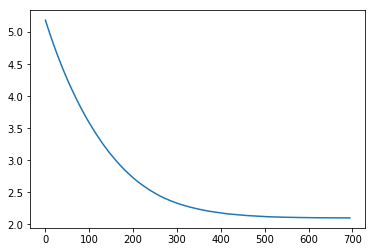

In [90]:
plt.figure()
plt.plot(result['test-mae-mean'])

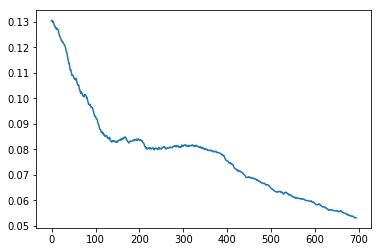

In [91]:
plt.figure()
plt.plot(result['test-mae-std'])

In [52]:
print(f"best_score={best_score}")

best_score=2.0750172


In [57]:
best_params

{'learning_rate': 0.005,
 'max_depth': 7,
 'min_child_weight': 1,
 'colsample_bytree': 0.7,
 'subsample': 0.5,
 'objective': 'reg:linear',
 'eval_metric': 'mae',
 'n_estimators': 10000,
 'nthread': 32,
 'random_state': 42}

In [62]:
scores_val_original = []
for fold_, (trn_, val_) in enumerate(folds.split(X)):
    print("Current Fold: {}".format(fold_))
    trn_x, trn_y = X.iloc[trn_], y.iloc[trn_]
    val_x, val_y = X.iloc[val_], y.iloc[val_]

    clf = xgb.XGBRegressor(**best_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric='mae',
        verbose=500,
        early_stopping_rounds=200
    )
    val_pred = clf.predict(val_x, ntree_limit=clf.best_ntree_limit)
    test_fold_pred = clf.predict(X_test, ntree_limit=clf.best_ntree_limit)
    score = metrics.mean_absolute_error(val_y, val_pred)
    print(f"MAE = {score:.4f}")    
    scores_val_original.append(score)
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
test_preds /= n_splits

best_score_mean_retrained = np.mean(scores_val_original)
best_score_std_retrained = np.std(scores_val_original)

oof_score = metrics.mean_absolute_error(y, oof_preds)
print(f"Mean MAE = {best_score_mean_retrained:.4f} - Std MAE = {best_score_std_retrained:.4f}")

Current Fold: 0
[0]	validation_0-mae:5.18879	validation_1-mae:5.16517
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.50396	validation_1-mae:2.10052
Stopping. Best iteration:
[569]	validation_0-mae:1.43888	validation_1-mae:2.095

MAE = 2.0950
Current Fold: 1
[0]	validation_0-mae:5.19091	validation_1-mae:5.15588
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.50029	validation_1-mae:2.10434
Stopping. Best iteration:
[615]	validation_0-mae:1.39812	validation_1-mae:2.09926

MAE = 2.0993
Current Fold: 2
[0]	validation_0-mae:5.22434	validation_1-mae:5.02235
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.49841	validation_1-mae:2.06614
Stopping. Best iteration:
[522]	validation_0-mae:1.47579	validation_1-mae:2.06516

MAE = 2.0652
Current Fold: 3
[0]	validation_0-mae:5.14392	validation_1-mae:5.34394
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.50157	validation_1-mae:2.02411
Stopping. Best iteration:
[574]	validation_0-mae:1.43223	validation_1-mae:2.01498

MAE = 2.0150
Current Fold: 4
[0]	validation_0-mae:5.17131	validation_1-mae:5.23419
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.501	validation_1-mae:2.12707
Stopping. Best iteration:
[794]	validation_0-mae:1.28518	validation_1-mae:2.10866

MAE = 2.1087
Mean MAE = 2.0766
Mean MAE = 2.0766 - Std MAE = 0.0341


This is the original Kernel

In [54]:
params = {
    "learning_rate": 0.01,
    "max_depth": 4,
    "n_estimators": 10000,
    "min_child_weight": 1,
    "colsample_bytree": 0.9,
    "subsample": 1.0,
    "nthread": 12,
    "random_state": 42,
}
scores_val_original = []
for fold_, (trn_, val_) in enumerate(folds.split(X)):
    print("Current Fold: {}".format(fold_))
    trn_x, trn_y = X.iloc[trn_], y.iloc[trn_]
    val_x, val_y = X.iloc[val_], y.iloc[val_]

    clf = xgb.XGBRegressor(**params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric='mae',
        verbose=500,
        early_stopping_rounds=200
    )
    val_pred = clf.predict(val_x, ntree_limit=clf.best_ntree_limit)
    test_fold_pred = clf.predict(X_test, ntree_limit=clf.best_ntree_limit)
    score = metrics.mean_absolute_error(val_y, val_pred)
    print(f"MAE = {score}:.4f")    
    scores_val_original.append(score)
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
test_preds /= n_splits

original_score_mean = np.mean(scores_val_original)
original_score_std = np.std(scores_val_original)

oof_score = metrics.mean_absolute_error(y, oof_preds)
print("Mean MAE = {}".format(oof_score))

Current Fold: 0
[0]	validation_0-mae:5.16504	validation_1-mae:5.14136
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[264]	validation_0-mae:1.88955	validation_1-mae:2.13085

MAE = 2.1308532280079038:.4f
Current Fold: 1
[0]	validation_0-mae:5.16712	validation_1-mae:5.13129
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[259]	validation_0-mae:1.89948	validation_1-mae:2.11642

MAE = 2.116422236311507:.4f
Current Fold: 2
[0]	validation_0-mae:5.20024	validation_1-mae:4.9985
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[241]	validation_0-mae:1.92268	validation_1-mae:2.07896

MAE = 2.0789616590329008:.4f
Current Fold: 3
[0]	validation_0-mae:5.12026	validation_1-mae:5.31974
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.7979	validation_1-mae:2.02507
Stopping. Best iteration:
[314]	validation_0-mae:1.87232	validation_1-mae:2.02001

MAE = 2.0200131961855883:.4f
Current Fold: 4
[0]	validation_0-mae:5.14774	validation_1-mae:5.21103
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.


/local/user/toolse64/ubuntu/18.04/usr/local/tools/anaconda_2018.12/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[500]	validation_0-mae:1.79846	validation_1-mae:2.1141
Stopping. Best iteration:
[310]	validation_0-mae:1.85902	validation_1-mae:2.11332

MAE = 2.1133190251155805:.4f
Mean MAE = 2.091913868930696


2.0766115265472562

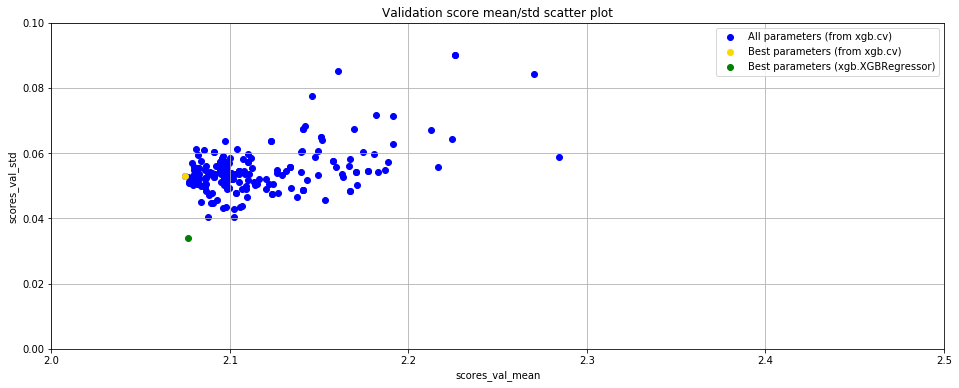

In [70]:
plt.figure(figsize=(16, 6))
plt.scatter(scores_val_mean, scores_val_std, color='blue')
plt.scatter(best_score, best_score_std, color='gold')
#plt.scatter(original_score_mean, original_score_std, color='red')
plt.scatter(best_score_mean_retrained, best_score_std_retrained, color='green')
plt.xlim([2, 2.5])
plt.ylim([0, 0.1])
plt.xlabel('scores_val_mean')
plt.ylabel('scores_val_std')
plt.title('Validation score mean/std scatter plot')
plt.grid()
plt.legend(['All parameters (from xgb.cv)', 'Best parameters (from xgb.cv)', 'Best parameters (xgb.XGBRegressor)'])
plt.show()

In [ ]:
submission = pd.DataFrame(columns=['seg_id', 'time_to_failure'])
submission.seg_id = test_segs
submission.time_to_failure = test_preds
submission.to_csv('submission.csv', index=False)